In light of deepseeks MOE model outperforming complex LLMs we would like to test the same archietcture to simplify, improve and accelerate neural bounding. We rework our neural bounding tree architecture into a simpler MOE.

One small gating MLP and two small expert MLPs. Coordinate in and colour out.

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import IPython as ip

- Load image
- Add helper functions

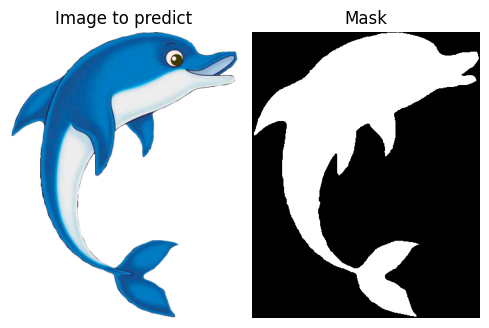

In [2]:
def generate_samples(img, mask, n_samples = 10):    
    # Create n samples from image 
    # Sample: X, Y coordinatem (Input to model) in image and R, G, B value (Label)

    # Generate n random image coordinates
    width, height = img.shape[1], img.shape[0]
    y, x = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
    coords = np.stack((y,x), axis=-1).reshape(width*height,2).astype(float)
    x = (np.random.random(n_samples) * coords.shape[0])
    x = coords[x.astype(int)]

    # Generate sample mask
    m = mask[x[...,0].astype(int), x[...,1].astype(int)]

    # Query n labels
    y = img[x[...,0].astype(int), x[...,1].astype(int), 0:3]
    x[...,0] /= height
    x[...,1] /= width

    return torch.from_numpy(x).float(), torch.from_numpy(y).float(), m.bool()

img_col = plt.imread("dolphin_color.png")
img_mask = torch.from_numpy(img_col[...,3] == 1).float()

fig, ax = plt.subplots(1,2,figsize=(5,10))
ax[0].imshow(img_col)
ax[0].set_title("Image to predict")
ax[1].imshow(img_mask, cmap="gray")
ax[1].set_title("Mask")
for a in ax: a.axis("off")
fig.tight_layout()
plt.show()

Network implementation

In [256]:
#Gate computes binary expert activation as probability distribution of experts, where
#we pick the top K following DeepSeekMoE 2024 architecture
class Gate(nn.Module):
  def __init__(self, no_experts):
    super().__init__()
    self.gate_stack = nn.Sequential(
        nn.Linear(2, no_experts),
        nn.Softmax(dim=1)
    )
  def forward(self, x):
    return self.gate_stack(x)


class Expert(nn.Module):
  def __init__(self):
    super().__init__()
    self.expert_stack = nn.Sequential(
        nn.Linear(2, 5), 
        nn.ReLU(),
        nn.Linear(5, 1), 
        nn.ReLU(),
    )
  def forward(self, x):
    return self.expert_stack(x)
  

# Moe architecture that allows to define number of experts
class MoE(nn.Module):
  def __init__(self, no_experts):
    super().__init__()
    self.gate = Gate(no_experts)
    self.experts = nn.ModuleList()
    for i in range(no_experts):
      self.experts.append(Expert())
    self.expert_shared = Expert()

  def forward(self, x):
    # Compute outputs for all networks 

    outputs = torch.stack([self.experts[i](x) for i in range(len(self.experts))]).reshape(x.shape[0],len(self.experts))

    # Forward x through gate network and get indicies of top k of activation distribution
    v , activated_expert_indicies = torch.topk(self.gate(x), 3)
    selection_mask = torch.isin(torch.tile(torch.tensor(np.arange(len(self.experts))),(x.shape[0],1)), activated_expert_indicies)

    # Binary selection of top K expert outputs
    activated_expert_sum = torch.sum(outputs[selection_mask], dim=-1)

    # Forward through shared expert and sum output
    shared_expert_sum = self.expert_shared(x).squeeze()
    output = shared_expert_sum + activated_expert_sum

    return output

Training loop

In [257]:
# Training Hyperparameters
iterations, eval = 100, 10
model = MoE(6)
criterion = nn.MSELoss()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

# Training iterations of model
for i in range(iterations):

    # Generate training data / samples from image for this iteration
    features, targets, mask = generate_samples(img=img_col, mask=img_mask, n_samples=10000)
    
    # forward pass
    output = model.forward(features)

    # compute loss and zero loss if sample not in mask and UNDEFINED
    output[~mask] = targets[~mask]
    loss = criterion(output, targets)

    # zero gradients, backward pass, optimiser step
    optimiser.zero_grad()
    loss.backward()
    optimiser.step()

    if i % eval == 0:
        # Generate all image coordinates
        width, height = img_col.shape[1], img_col.shape[0]
        y, x = np.meshgrid(np.arange(height), np.arange(width), indexing="ij")
        coords = np.stack((y,x), axis=-1).reshape(width*height,2).astype(float)
        x = coords.copy()
        x[...,0] /= height
        x[...,1] /= width
        est_img = model.forward(torch.from_numpy(x).float())
        est_img = np.clip(est_img.reshape(height,width,3).detach().numpy(),0, 1)

        ip.display.clear_output(wait=True)
        plt.imshow(est_img)
        plt.title(f"Iteration: {i}, Loss: {np.round(loss.detach().numpy(), 4)}")
        plt.axis("off")
        plt.show()

RuntimeError: shape mismatch: value tensor of shape [6685, 3] cannot be broadcast to indexing result of shape [6685]

PROTTYPING

In [4]:
# Define some simple networks
class SimpleNet(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.fc = nn.Linear(in_features, out_features)
    
    def forward(self, x):
        return self.fc(x)

# Create a ModuleList of networks
networks = nn.ModuleList([
    SimpleNet(3, 2),
    SimpleNet(3, 2),
    SimpleNet(3, 2)
])

# Example input
x = torch.randn(3)  # Input tensor

# Binary mask: only forward to networks at indices where mask == 1
mask = torch.tensor([1, 0, 1], dtype=torch.bool)  # Process only network 0 and 2

networks[mask]

# # Forward pass through selected networks
# outputs = [net(x) for net, m in zip(networks, mask) if m]

# # Print outputs
# for i, out in enumerate(outputs):
#     print(f"Output from selected network {i}: {out}")


TypeError: only integer tensors of a single element can be converted to an index